In [ ]:
# Etape 1 : preprocessing
# Etape 1.5 (Optionelle): Ajout de Bi-Gramme
# Etape 2 : Word2Vec / paramètres : Méthode : Skip-Gram, Cbow / window / taille du vecteur
# Etape 3 : Un commentaire = un vecteur ( on fait la moyenne des vecteurs mots du commentaire) , ok car commentaire peu grand en mots
# Etape 3.5 (Optionnelle) : Réduction de dimension pour K-means / sinon Etape 2 : réduire taille du vecteur en paramètre
# Etape 4 : K-means (Classification)
# Etape 5 : Nuage de mots par thème issue du clustering


# Autre Méthode que Word2Vec : Utiliser LDA
# Rendre le début illisible -> effet redempteur avec la fin quand on degage les thèmes

# Packages / Librairies

In [ ]:
!pip install gensim

In [ ]:
!pip install wordcloud

In [ ]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 15.1 MB/s eta 0:00:00


In [ ]:
!python -m spacy download fr_core_news_md

2023-06-29 12:11:22.347929: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 12:11:24.994036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 12.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')


In [ ]:
# !pip install gensim pyLDAvis

In [ ]:
import pandas as pd
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import unidecode
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from gensim import corpora
from gensim.models import LdaModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
# import pyLDAvis.gensim_models
from sklearn.feature_selection import chi2
import numpy as np

# Téléchargement Spacy

In [ ]:
nlp = spacy.load('fr_core_news_md')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Dataframe : récupérer données

In [ ]:
# Charger le fichier json
#with open('ensai2023_mieuxmanger.json', 'r') as f:
#    data = json.load(f)

# Créer un DataFrame à partir des données JSON
#df = pd.json_normalize(data['results'])

df = pd.read_csv('data_des_votes.csv')



# Aperçu / Statistiques

In [ ]:
df.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['id', 'userId', 'content', 'contentLanguage', 'translatedContent',
       'translatedLanguage', 'slug', 'status', 'createdAt', 'updatedAt',
       'votes', 'organisations', 'tags', 'myProposal', 'idea', 'operationId',
       'proposalKey', 'keywords', 'context.operation', 'context.source',
       'context.location', 'context.questionSlug', 'context.country',
       'context.questionLanguage', 'context.proposalLanguage',
       'context.clientLanguage', 'context.getParameters', 'author.firstName',
       'author.displayName', 'author.organisationName',
       'author.organisationSlug', 'author.postalCode', 'author.age',
       'author.avatarUrl', 'author.userType', 'selectedStakeTag.tagId',
       'selectedStakeTag.label', 'selectedStakeTag.display',
       'question.questionId', 'question.slug', 'question.wording.title',
       'question.wording.question', 'question.countries',
       'question.preferredLanguage', 'question.returnedLanguage',
       'question.startDate', 'questi

In [ ]:
df.head()

,Unnamed: 0,id,content,author.age,agree_count,neutral_count,disagree_count,agree_score,neutral_score,disagree_score,likeit_count,platitudeAgree_count,doable_count,noOpinion,doNotUnderstand,doNotCare,impossible,noWay,platitudeDisagree
0,1,7292af05-8026-437c-8192-849ad9813f36,Il faut preter des liseuses,52.0,72,52,46,0.42,0.31,0.27,14,7,22,17,0,13,9,19,8
1,2,ad184825-c69f-4639-b790-83412f6b0d1c,"Il faut faire connaitre le site Babelio et autres sites ou blogs ou video blogs littéraires ,; toute une communauté d'amateurs passionnés",64.0,78,75,10,0.48,0.46,0.06,16,4,29,25,3,24,0,2,4
2,3,49b814de-571e-4cc4-a80f-e422a3af58f2,Il faut que les emprunts dans les bibliothèques soient gratuits pour tous,50.0,123,26,20,0.72,0.16,0.12,25,10,37,5,0,8,6,7,2
3,4,df5fe8d7-3ee7-4aed-8517-2eea8bfa19f6,Il faut éviter de parler avec des sigles qui sont inconnus et ont plus-value sens BDP Biblio Prêt mais aussi Balance des Paiements + autres,120.0,65,80,36,0.35,0.44,0.21,5,5,27,12,40,10,3,3,18
4,5,b6d3cc08-7c14-4e48-baaf-63b5ad81ff63,Il faut mettre à bas le système capitaliste.,47.0,53,73,45,0.30,0.44,0.26,20,6,5,12,31,9,5,8,16


# Traitement des données

In [ ]:
def preprocess_text(text):
    # Suppression des majuscules
    text = text.lower()

    # Suppression des accents
    text = unidecode.unidecode(text)

    # Suppression de la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = nltk.corpus.stopwords.words('french')
    # Tokenisation et lemmatisation
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.lemma_ not in stop_words and not token.is_punct and token.lemma_ != 'falloir' and token.lemma_ != 'avoir' and token.lemma_ != 'être' and token.lemma_ != 'tout' and token.lemma_ != 'comme' and token.lemma_ != 'plus']

    return lemmas

In [ ]:
def preprocess_text2(text):
    # Suppression des majuscules
    text = text.lower()

    # Suppression des accents
    text = unidecode.unidecode(text)

    # Suppression de la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = nltk.corpus.stopwords.words('french')
    # Tokenisation et lemmatisation
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.lemma_ not in stop_words and not token.is_punct and token.lemma_ != 'falloir' and token.lemma != 'avoir' and token.lemma ]

    return ' '.join(lemmas)

In [ ]:
df['clean_content'] = df['content'].apply(preprocess_text2)

In [ ]:
df['processed_content'] = df['content'].apply(preprocess_text)

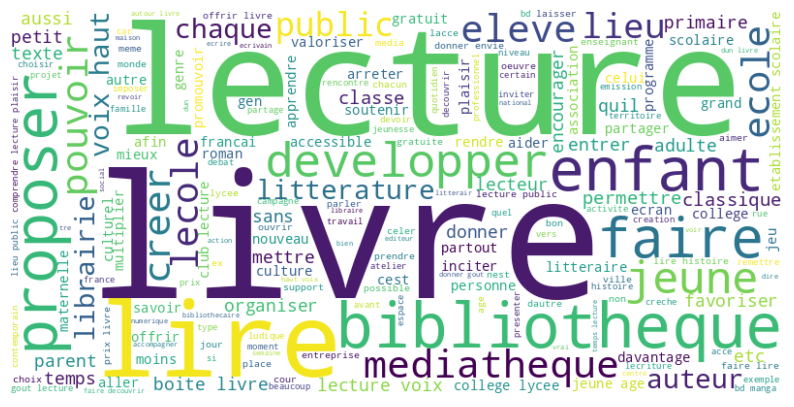

In [ ]:
# Nuage de mots
#stopwords = ["lecture", "livre", "avoir", "plus", "être" , "tout", "lire", "proposer", "bibliotheque", "literrature", "proposer", "faire", " "]
#words = [word for word in words if word not in stopwords]
all_words = ' '.join([' '.join(words) for words in df['processed_content']])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Rajouter commentaires
sentences = df['processed_content'].tolist()

# defaut = CBOW sg = 0
# Paramètres : CBOW/SKIP GRAM / WINDOW (VOISINS) / taille du vecteur
model = Word2Vec(sentences, vector_size=100, window=10, min_count=1, sg = 1)
model.train(sentences, total_examples=len(sentences), epochs=10)

(179518, 226660)

In [ ]:
sentences

In [ ]:
# (Optionnelle) : Réduction de dimension pour K-means / sinon Etape 2 : réduire taille du vecteur en paramètre

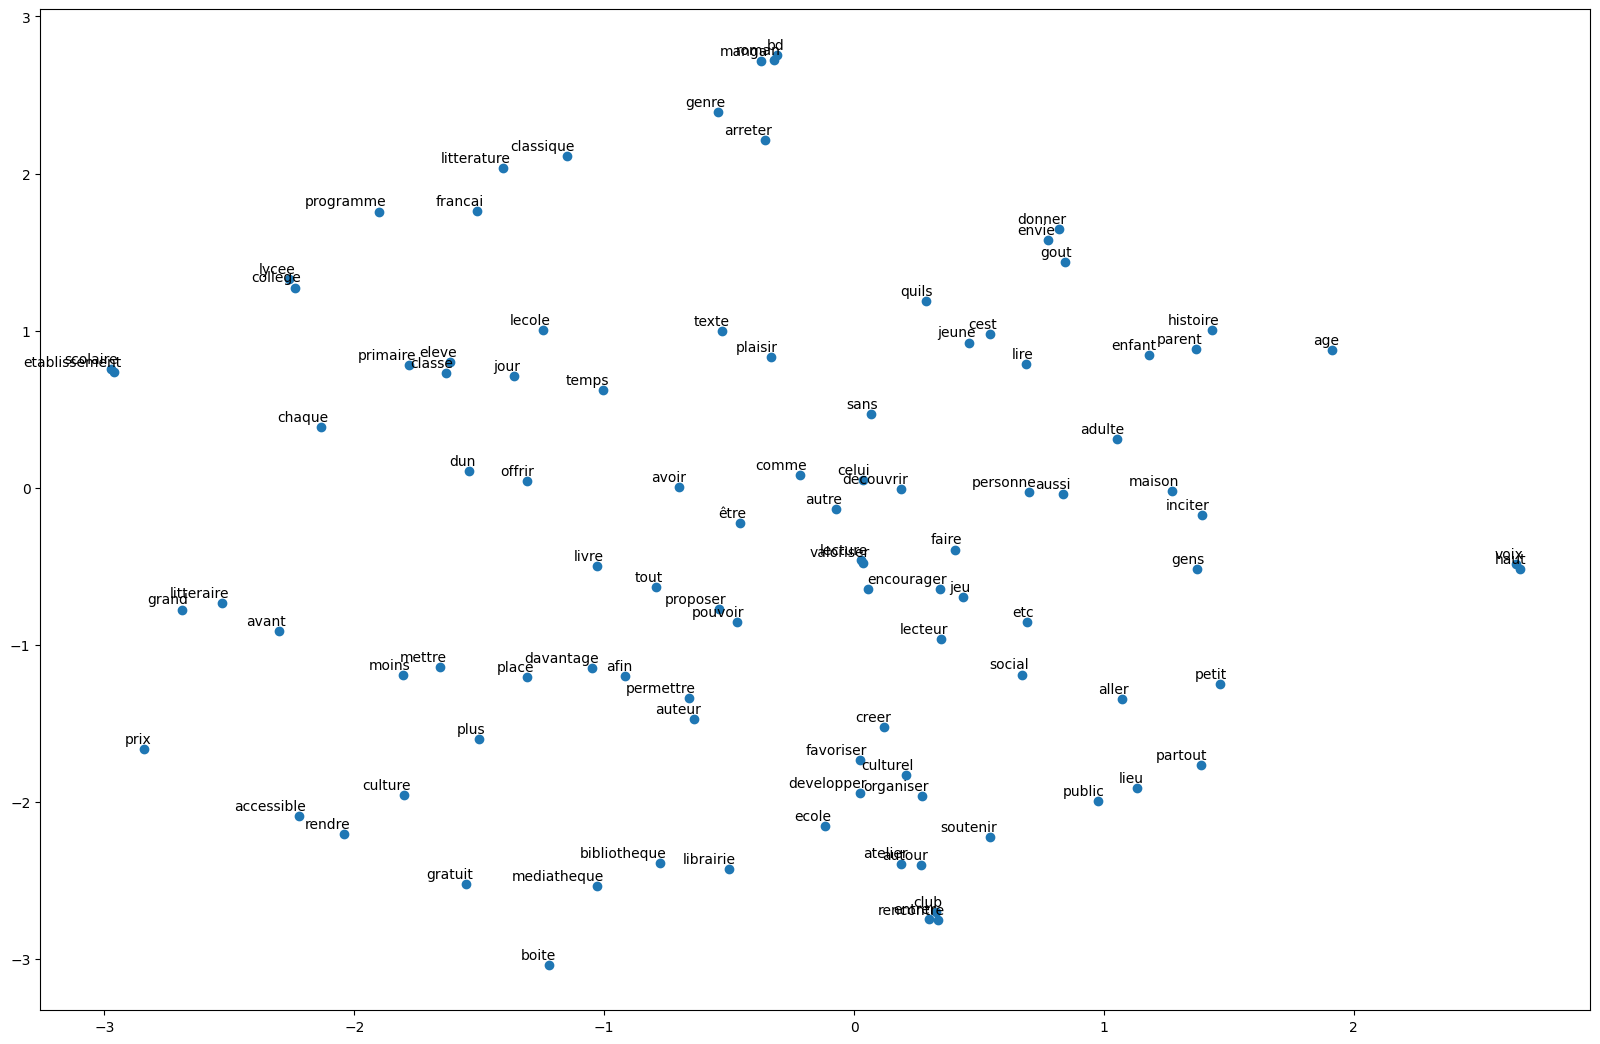

In [ ]:
# Récupérez les vecteurs de mots et les étiquettes correspondantes
# Supposons que `model` est votre modèle d'embedding de mots
word_vectors = model.wv.vectors[:100]
word_labels = model.wv.index_to_key[:100]


# Effectuez la réduction de dimensionnalité t-SNE
tsne = TSNE(perplexity = 50, n_components=2, random_state=42, n_iter = 5000)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Visualisez les résultats
plt.figure(figsize=(20, 13))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1])
for label, x, y in zip(word_labels, word_vectors_2d[:, 0], word_vectors_2d[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()


In [ ]:
comment_vectors = [np.mean([model.wv[word] for word in comment if word in model.wv], axis=0) for comment in sentences]
comment_vectors = np.array(comment_vectors, dtype=np.float32)  # Convertir en tableau numpy

tsne = TSNE(perplexity=70, n_components=2, random_state=42, n_iter=5000)
comment_vectors_2d = tsne.fit_transform(comment_vectors)

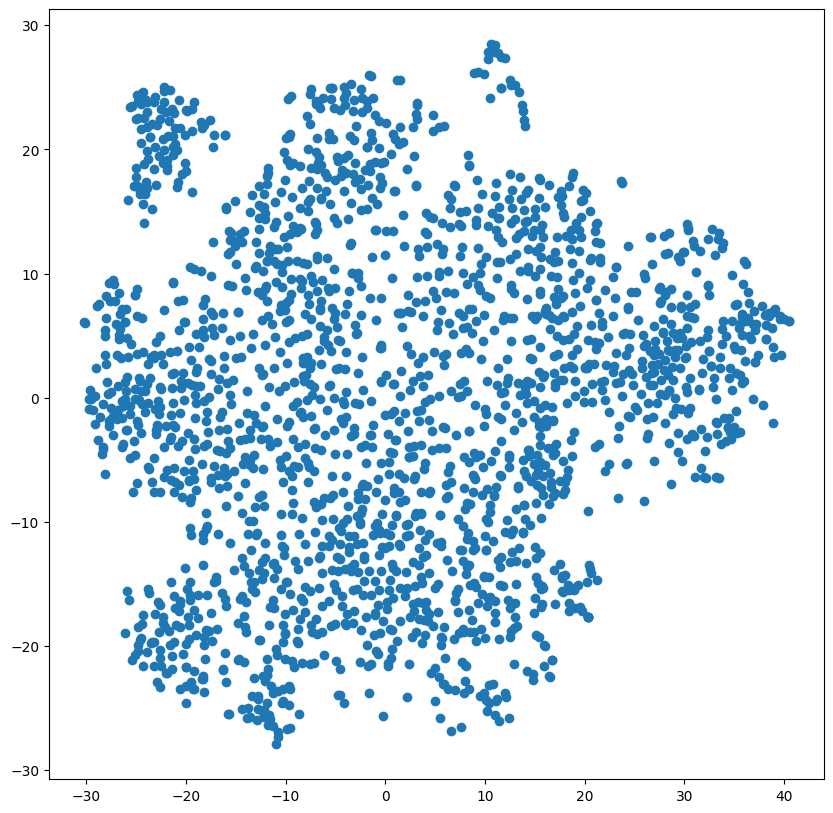

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(comment_vectors_2d[:, 0], comment_vectors_2d[:, 1])
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

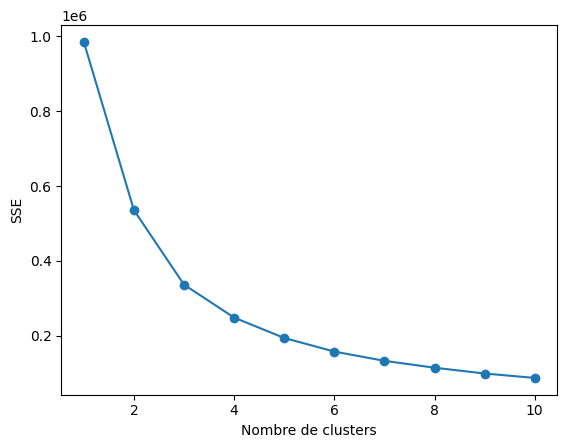

In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

sse = []
for k in range(1, 11): # Test de 1 à 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(comment_vectors_2d)
    sse.append(kmeans.inertia_) # SSE (Sum of Squared Errors) pour chaque 'k'

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('SSE')
plt.show()

In [ ]:
# Création du modèle K-means
# Ici, j'utilise 5 comme nombre de clusters, mais vous devriez utiliser le nombre qui semble le meilleur d'après la méthode du coude ou votre intuition
kmeans = KMeans(n_clusters=5, random_state=42)

# Adapter le modèle aux données
kmeans.fit(comment_vectors_2d)

# Ajouter les labels des clusters à votre DataFrame
df['cluster_label'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
df['cluster_label'].value_counts()

3    459
2    419
4    412
1    395
0    388
Name: cluster_label, dtype: int64

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
stopwords = ["lecture", "livre", "avoir", "plus", "être" , "tout", "lire", "proposer", "bibliotheque", "literrature", "proposer", "faire", " "]

# pour chaque cluster
for i in range(5):  # Remplacez 3 par le nombre de clusters que vous avez choisi
    print(f"Cluster {i}:")
    cluster = df[df['cluster_label'] == i]

    # Créez une liste de tous les mots dans le cluster, à l'exception des mots dans stopwords
    words = []
    for content in cluster['processed_content']:
          words.extend([word for word in content if word not in stopwords])

    # Comptez la fréquence de chaque mot
    word_freq = Counter(words)

    # Affichez les 10 mots les plus courants
    print(word_freq.most_common(50))
    print("\n")


Cluster 0:
[('classique', 57), ('litterature', 54), ('bd', 46), ('jeune', 44), ('roman', 44), ('arreter', 40), ('manga', 35), ('donner', 33), ('contemporain', 27), ('enfant', 27), ('lecole', 26), ('francai', 26), ('genre', 24), ('programme', 24), ('comme', 21), ('aussi', 20), ('cest', 20), ('envie', 20), ('plaisir', 20), ('pouvoir', 19), ('texte', 19), ('nest', 18), ('support', 17), ('decouvrir', 16), ('montrer', 16), ('college', 16), ('celui', 15), ('revoir', 15), ('dautre', 15), ('aimer', 15), ('auteur', 15), ('parler', 14), ('oeuvre', 14), ('valoriser', 14), ('sans', 14), ('adulte', 14), ('autre', 13), ('dire', 13), ('lecteur', 13), ('personne', 13), ('encourager', 13), ('etc', 13), ('grand', 12), ('type', 12), ('jeuness', 12), ('certain', 11), ('cours', 11), ('lycee', 11), ('celer', 11), ('gout', 11)]


Cluster 1:
[('scolaire', 65), ('college', 62), ('organiser', 51), ('lycee', 48), ('ecole', 45), ('auteur', 40), ('developper', 38), ('classe', 36), ('etablissement', 35), ('autour',

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


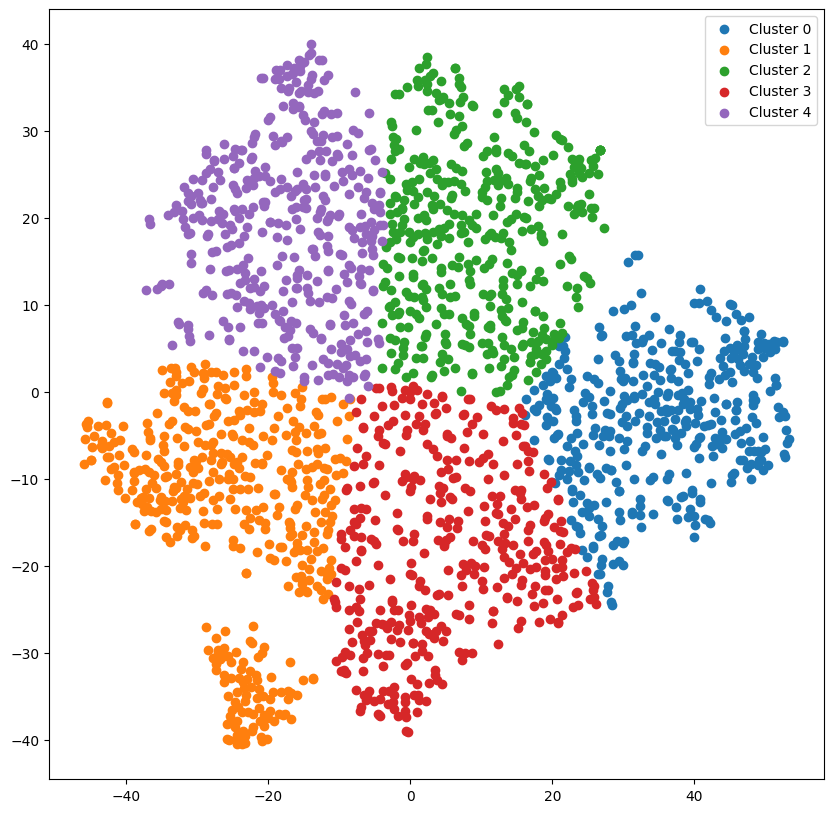

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# Création du modèle K-means
# Ici, j'utilise 5 comme nombre de clusters, mais vous devriez utiliser le nombre qui semble le meilleur d'après la méthode du coude ou votre intuition
kmeans = KMeans(n_clusters=5, random_state=42)

# Adapter le modèle aux données
kmeans.fit(comment_vectors_2d)

# Obtenir les étiquettes de cluster pour chaque commentaire
labels = kmeans.labels_

# Créer un scatter plot avec une couleur différente pour chaque cluster
plt.figure(figsize=(10, 10))

for i in range(kmeans.n_clusters):
    # Trouver les points dans ce cluster
    cluster_points = comment_vectors_2d[labels == i]
    # Dessinez ces points avec une nouvelle couleur
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i}")

# Affichez la légende
plt.legend()

plt.show()


Cluster 0:


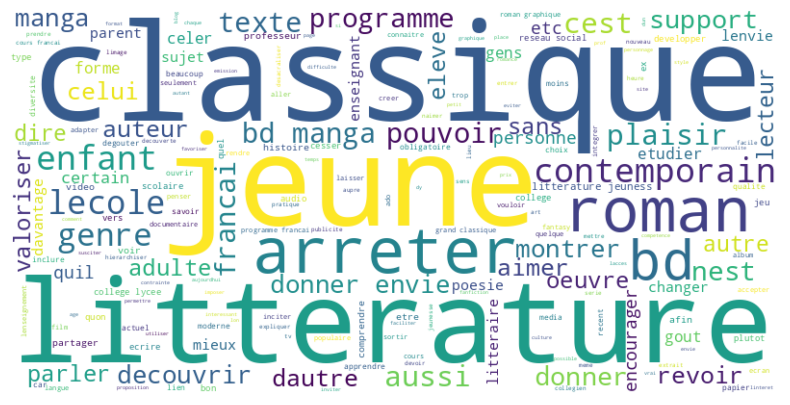

Cluster 1:


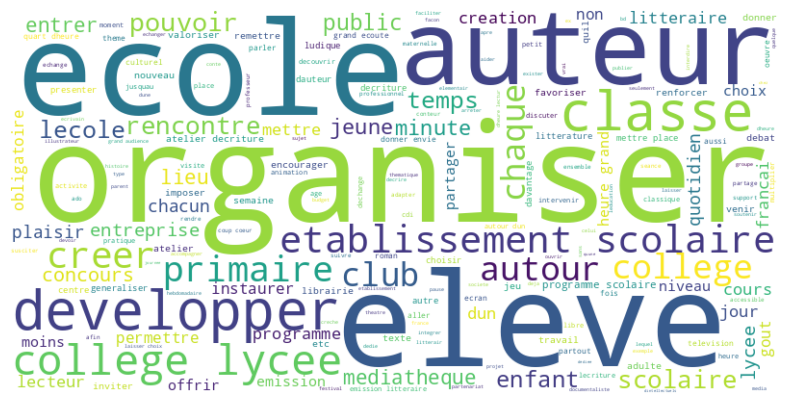

Cluster 2:


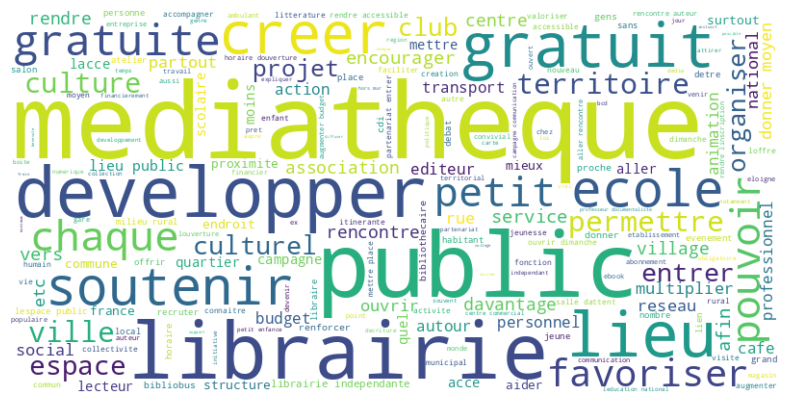

Cluster 3:


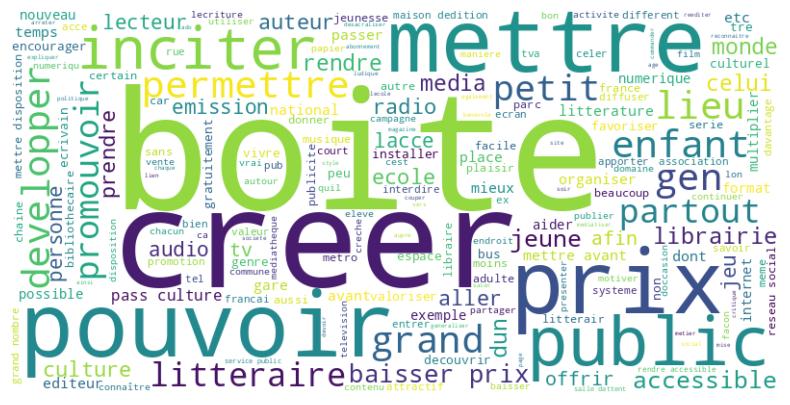

Cluster 4:


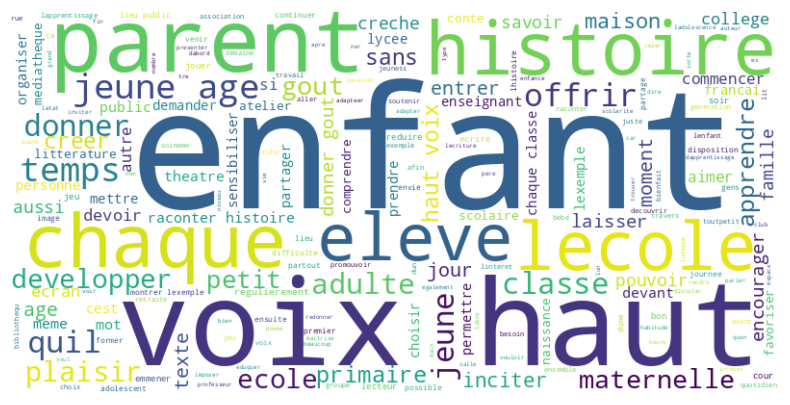

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Liste des mots à supprimer
stopwords = ["lecture", "livre", "avoir", "plus", "être" , "tout", "lire", "proposer", "bibliotheque", "literrature", "proposer", "faire", "comme"]

# Pour chaque cluster
for i in range(5):
    print(f"Cluster {i}:")
    cluster = df[df['cluster_label'] == i]

    # Créez une liste de tous les mots dans le cluster
    words = []
    for content in cluster['processed_content']:
        words.extend(content)

    # Supprimez les mots indésirables de la liste de mots
    words = [word for word in words if word not in stopwords]

    # Créez un nuage de mots à partir de cette liste
    wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join(words))

    # Affichez le nuage de mots
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


In [ ]:
# Pour chaque cluster
for i in range(5):  # Remplacez 2 par le nombre de clusters que vous avez choisi
    print(f"Cluster {i}:")

    # Récupérer le cluster
    cluster = df[df['cluster_label'] == i]

    # Somme totale des 'agree' et 'disagree' dans le cluster
    total_agree = cluster['agree_count'].sum()
    total_disagree = cluster['disagree_count'].sum()

    # Calculez le total des votes
    total_votes = total_agree + total_disagree

    # Calculez les pourcentages
    agree_percentage = (total_agree / total_votes) * 100
    disagree_percentage = (total_disagree / total_votes) * 100

    mean_age = cluster['author.age'].mean()

    # Calculez le nombre de commentaires dans le cluster
    num_comments = len(cluster)

    print(f"Nombre de commentaires: {num_comments}")
    print(f"Age moyen: {mean_age}")
    print(f"% Agree: {agree_percentage}%")
    print(f"% Disagree: {disagree_percentage}%")
    print("\n--------------------------------------\n")


Cluster 0:
Nombre de commentaires: 388
Age moyen: 46.03389830508475
% Agree: 84.20529801324503%
% Disagree: 15.794701986754966%

--------------------------------------

Cluster 1:
Nombre de commentaires: 395
Age moyen: 48.861189801699716
% Agree: 86.68533426671333%
% Disagree: 13.314665733286665%

--------------------------------------

Cluster 2:
Nombre de commentaires: 419
Age moyen: 50.84615384615385
% Agree: 89.38099106417546%
% Disagree: 10.619008935824532%

--------------------------------------

Cluster 3:
Nombre de commentaires: 459
Age moyen: 49.38256658595642
% Agree: 80.72318122806173%
% Disagree: 19.276818771938263%

--------------------------------------

Cluster 4:
Nombre de commentaires: 412
Age moyen: 51.986301369863014
% Agree: 86.59107063160157%
% Disagree: 13.408929368398434%

--------------------------------------



In [ ]:
# Pour chaque cluster
for i in range(2):
    print(f"Cluster {i}:")

    # Récupérer le cluster
    cluster = df[df['cluster_label'] == i]

    # Tri du dataframe selon 'agree_count' (votes positifs)
    sorted_cluster_positive = cluster.sort_values(by='agree_count', ascending=False)

    # Tri du dataframe selon 'disagree_count' (votes négatifs)
    #sorted_cluster_negative = cluster.sort_values(by='disagree_count', ascending=False)

    # Afficher les commentaires ayant le plus de votes positifs
    print("\nTop commentaires avec le plus de votes positifs :")
    print(sorted_cluster_positive[['content', 'agree_count']].head())

    # Afficher les commentaires ayant le plus de votes négatifs
    #print("\nTop commentaires avec le plus de votes négatifs :")
    #print(sorted_cluster_negative[['content', 'disagree_count']].head())
    #print("\n--------------------------------------\n")


Cluster 0:

Top commentaires avec le plus de votes positifs :
                                                                                                                                         content  \
182                                       Il faut que l'Éducation nationale fasse de la place pour la lecture plaisir, sans enjeu ni évaluation.   
1427                Il faut généraliser les 1/4 heures lecture et autres temps de lecture dans les établissements scolaires y compris en lycée !   
1425  Il faut mener plus d'actions en faveur de la lecture plaisir dans les écoles : cercles de lecture, boîtes à livres dans les cours de récré   
579   Il faut donner le goût à la lecture dès le plus jeune âge. Les bonnes habitudes ne se perdent pas. Inscrire les enfants à la bibliothèque.   
626                          Il faut encourager la création de clubs de lecture à l’école, à l’université, à la bibliothèque, au café… partout !   

      agree_count  
182           389  
1427     

In [ ]:
from sklearn.cluster import KMeans

# Supposons que nous voulons 5 clusters
true_k = 5

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)

model.fit(features)

# Maintenant, chaque document est assigné à un cluster
df['cluster'] = model.labels_

# Pour obtenir les termes les plus importants pour chaque cluster, nous pouvons trier les
# caractéristiques (termes) selon leur distance au centre du cluster
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names_out()

for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:  # nombre de mots par cluster
        print(' %s' % terms[ind]),
    print


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cluster 0:
 haut
 voix
 avoir voix
 voix haut
 lecture avoir
 avoir
 lecture
 avoir haut
 haut voix
 lire
Cluster 1:
 avoir
 livre
 lire
 avoir livre
 tout
 avoir lire
 livre avoir
 boite
 boite avoir
 enfant
Cluster 2:
 livre
 plus
 faire
 être
 lire
 avoir
 jeune
 litterature
 librairie
 auteur
Cluster 3:
 lecture
 avoir
 scolaire
 college
 proposer
 plus
 être
 tout
 lycee
 lire
Cluster 4:
 bibliotheque
 mediatheque
 tout
 gratuit
 gratuite
 plus
 public
 être
 lieu
 rendre
